In [39]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.linalg import pinv

import ConnectionNetworkX_v2 as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyLDLE2 import datasets, visualize_

In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX_v2' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX_v2.py'>

# Load torus data

In [3]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=1000)

X.shape =  (1000, 3)


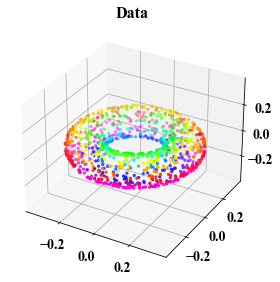

In [4]:
%matplotlib inline
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

#  build connection graph

In [5]:
NEAREST_NEIGHBORS = 13
INTRINSIC_DIMENSION = 2

CG = cnx.cnxFromData(X, k=NEAREST_NEIGHBORS, d=INTRINSIC_DIMENSION)

local_opts['k_nn0'] = 49 is created.
Options provided:
local_opts:
{
    "Atilde_method": "LDLE_1",
    "N": 100,
    "U_method": "k_nn",
    "algo": "LPCA",
    "alpha": 1,
    "debug": true,
    "delta": 0.9,
    "gl_type": "unnorm",
    "k": 13,
    "k_nn": 49,
    "k_nn0": 49,
    "k_tune": 7,
    "lambda1_decay": 0.75,
    "lambda1_init": 8,
    "lambda1_min": 0.001,
    "max_iter": 300,
    "max_sparsity": 0.9,
    "metric": "euclidean",
    "n_proc": 32,
    "p": 0.99,
    "power": 5,
    "pp_n_thresh": 32,
    "radius": 0.5,
    "reg": 0.0,
    "scale_by": "gamma",
    "tau": 50,
    "to_postprocess": true,
    "tuning": "self",
    "verbose": true
}
intermed_opts:
{
    "algo": "best",
    "debug": true,
    "eta_max": 1,
    "eta_min": 5,
    "len_S_thresh": 256,
    "local_algo": "LPCA",
    "n_proc": 32,
    "n_times": 4,
    "verbose": true
}
global_opts:
{
    "add_dim": false,
    "align_transform": "rigid",
    "align_w_parent_only": true,
    "alpha": 0.3,
    "beta": 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.48it/s]


Proportion of edges which were removed due to remoteness:  0.22053118472097882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.83it/s]


[-0.1322102  -0.10653037 -0.07965614 -0.03093307 -0.00357332  0.04250584
  0.05884136  0.07794703  0.11460837  0.14282107]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


# Set B, w, mu, nu, c

In [64]:
d = INTRINSIC_DIMENSION
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
W = np.ones(B.shape[0]//d).astype('float32')

np.random.seed(42)
source = np.random.randint(0, CG.number_of_nodes())
dest = np.random.randint(0, CG.number_of_nodes())

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = [[1],[1]]
nu[dest * d: (dest + 1) * d, :] = [[1],[1]]

c = (mu - nu)

In [65]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

/tmp/ipykernel_75780/426106341.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)


1.0943394135663999e-14

In [99]:
learning_rate = 0.001
alpha = 1
n_epochs = 20000

B_torch = torch.tensor(B.toarray().astype('float32'))
w_torch = torch.tensor(W.astype('float32'))
c_torch = torch.tensor(c.astype('float32'))
phi0 = -pinv(B.T.dot(B).toarray()).dot(c).astype('float32')
#phi0 = None

if phi0 is not None:
    print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B_torch, w_torch, c_torch))

phi = cnx.optimize(B_torch, w_torch, c_torch, alpha, learning_rate, n_epochs, phi0 = phi0).detach().numpy()

Initial loss: (tensor(0.3091), tensor(0.))
epoch: 0, loss: 0.309132, loss0: 0.309132, loss1: 0.000000
epoch: 10, loss: 0.269132, loss0: 0.269132, loss1: 0.000000
epoch: 20, loss: 0.229132, loss0: 0.229132, loss1: 0.000000
epoch: 30, loss: 0.189132, loss0: 0.189132, loss1: 0.000000
epoch: 40, loss: 0.149132, loss0: 0.149132, loss1: 0.000000
epoch: 50, loss: 0.109132, loss0: 0.109132, loss1: 0.000000
epoch: 60, loss: 0.069132, loss0: 0.069132, loss1: 0.000000
epoch: 70, loss: 0.029132, loss0: 0.029132, loss1: 0.000000
epoch: 80, loss: -0.010868, loss0: -0.010868, loss1: 0.000000
epoch: 90, loss: -0.050868, loss0: -0.050868, loss1: 0.000000
epoch: 100, loss: -0.090868, loss0: -0.090868, loss1: 0.000000
epoch: 110, loss: -0.130868, loss0: -0.130868, loss1: 0.000000
epoch: 120, loss: -0.170868, loss0: -0.170868, loss1: 0.000000
epoch: 130, loss: -0.210868, loss0: -0.210868, loss1: 0.000000
epoch: 140, loss: -0.250868, loss0: -0.250868, loss1: 0.000000
epoch: 150, loss: -0.290868, loss0: -0.

epoch: 1350, loss: -5.090110, loss0: -5.090110, loss1: 0.000000
epoch: 1360, loss: -5.130101, loss0: -5.130101, loss1: 0.000000
epoch: 1370, loss: -5.170092, loss0: -5.170092, loss1: 0.000000
epoch: 1380, loss: -5.210083, loss0: -5.210083, loss1: 0.000000
epoch: 1390, loss: -5.250074, loss0: -5.250074, loss1: 0.000000
epoch: 1400, loss: -5.290066, loss0: -5.290066, loss1: 0.000000
epoch: 1410, loss: -5.330057, loss0: -5.330057, loss1: 0.000000
epoch: 1420, loss: -5.370049, loss0: -5.370049, loss1: 0.000000
epoch: 1430, loss: -5.410041, loss0: -5.410041, loss1: 0.000000
epoch: 1440, loss: -5.450032, loss0: -5.450032, loss1: 0.000000
epoch: 1450, loss: -5.490023, loss0: -5.490023, loss1: 0.000000
epoch: 1460, loss: -5.530013, loss0: -5.530013, loss1: 0.000000
epoch: 1470, loss: -5.570002, loss0: -5.570002, loss1: 0.000001
epoch: 1480, loss: -5.609992, loss0: -5.609992, loss1: 0.000000
epoch: 1490, loss: -5.649981, loss0: -5.649981, loss1: 0.000000
epoch: 1500, loss: -5.689970, loss0: -5.

epoch: 2720, loss: -9.765054, loss0: -9.952616, loss1: 0.375124
epoch: 2730, loss: -9.768538, loss0: -9.960955, loss1: 0.384833
epoch: 2740, loss: -9.771840, loss0: -9.968823, loss1: 0.393967
epoch: 2750, loss: -9.774987, loss0: -9.976248, loss1: 0.402522
epoch: 2760, loss: -9.777997, loss0: -9.983267, loss1: 0.410539
epoch: 2770, loss: -9.780887, loss0: -9.989904, loss1: 0.418036
epoch: 2780, loss: -9.783664, loss0: -9.996191, loss1: 0.425055
epoch: 2790, loss: -9.786341, loss0: -10.002151, loss1: 0.431622
epoch: 2800, loss: -9.788927, loss0: -10.007808, loss1: 0.437762
epoch: 2810, loss: -9.791436, loss0: -10.013180, loss1: 0.443487
epoch: 2820, loss: -9.793877, loss0: -10.018286, loss1: 0.448818
epoch: 2830, loss: -9.796252, loss0: -10.023143, loss1: 0.453780
epoch: 2840, loss: -9.798571, loss0: -10.027773, loss1: 0.458404
epoch: 2850, loss: -9.800833, loss0: -10.032190, loss1: 0.462715
epoch: 2860, loss: -9.803040, loss0: -10.036416, loss1: 0.466753
epoch: 2870, loss: -9.805205, lo

epoch: 4070, loss: -9.891762, loss0: -10.176686, loss1: 0.569849
epoch: 4080, loss: -9.891829, loss0: -10.176840, loss1: 0.570021
epoch: 4090, loss: -9.891892, loss0: -10.176989, loss1: 0.570193
epoch: 4100, loss: -9.891954, loss0: -10.177132, loss1: 0.570354
epoch: 4110, loss: -9.892014, loss0: -10.177269, loss1: 0.570511
epoch: 4120, loss: -9.892070, loss0: -10.177402, loss1: 0.570666
epoch: 4130, loss: -9.892123, loss0: -10.177532, loss1: 0.570818
epoch: 4140, loss: -9.892177, loss0: -10.177658, loss1: 0.570964
epoch: 4150, loss: -9.892223, loss0: -10.177778, loss1: 0.571109
epoch: 4160, loss: -9.892275, loss0: -10.177894, loss1: 0.571238
epoch: 4170, loss: -9.892323, loss0: -10.178009, loss1: 0.571373
epoch: 4180, loss: -9.892367, loss0: -10.178122, loss1: 0.571509
epoch: 4190, loss: -9.892407, loss0: -10.178231, loss1: 0.571648
epoch: 4200, loss: -9.892448, loss0: -10.178337, loss1: 0.571778
epoch: 4210, loss: -9.892488, loss0: -10.178441, loss1: 0.571905
epoch: 4220, loss: -9.892

epoch: 5420, loss: -9.893516, loss0: -10.181273, loss1: 0.575514
epoch: 5430, loss: -9.893515, loss0: -10.181275, loss1: 0.575521
epoch: 5440, loss: -9.893516, loss0: -10.181281, loss1: 0.575530
epoch: 5450, loss: -9.893518, loss0: -10.181285, loss1: 0.575532
epoch: 5460, loss: -9.893520, loss0: -10.181286, loss1: 0.575532
epoch: 5470, loss: -9.893519, loss0: -10.181286, loss1: 0.575533
epoch: 5480, loss: -9.893521, loss0: -10.181286, loss1: 0.575529
epoch: 5490, loss: -9.893522, loss0: -10.181286, loss1: 0.575528
epoch: 5500, loss: -9.893521, loss0: -10.181287, loss1: 0.575530
epoch: 5510, loss: -9.893522, loss0: -10.181286, loss1: 0.575528
epoch: 5520, loss: -9.893523, loss0: -10.181284, loss1: 0.575521
epoch: 5530, loss: -9.893525, loss0: -10.181284, loss1: 0.575517
epoch: 5540, loss: -9.893524, loss0: -10.181282, loss1: 0.575515
epoch: 5550, loss: -9.893527, loss0: -10.181282, loss1: 0.575511
epoch: 5560, loss: -9.893523, loss0: -10.181282, loss1: 0.575518
epoch: 5570, loss: -9.893

epoch: 6770, loss: -9.893535, loss0: -10.181267, loss1: 0.575463
epoch: 6780, loss: -9.893537, loss0: -10.181267, loss1: 0.575461
epoch: 6790, loss: -9.893538, loss0: -10.181264, loss1: 0.575453
epoch: 6800, loss: -9.893538, loss0: -10.181264, loss1: 0.575454
epoch: 6810, loss: -9.893538, loss0: -10.181264, loss1: 0.575453
epoch: 6820, loss: -9.893538, loss0: -10.181266, loss1: 0.575457
epoch: 6830, loss: -9.893538, loss0: -10.181266, loss1: 0.575457
epoch: 6840, loss: -9.893538, loss0: -10.181267, loss1: 0.575457
epoch: 6850, loss: -9.893536, loss0: -10.181267, loss1: 0.575462
epoch: 6860, loss: -9.893536, loss0: -10.181267, loss1: 0.575462
epoch: 6870, loss: -9.893538, loss0: -10.181266, loss1: 0.575457
epoch: 6880, loss: -9.893538, loss0: -10.181264, loss1: 0.575454
epoch: 6890, loss: -9.893537, loss0: -10.181265, loss1: 0.575457
epoch: 6900, loss: -9.893535, loss0: -10.181264, loss1: 0.575458
epoch: 6910, loss: -9.893536, loss0: -10.181265, loss1: 0.575459
epoch: 6920, loss: -9.893

epoch: 8120, loss: -9.893535, loss0: -10.181258, loss1: 0.575447
epoch: 8130, loss: -9.893537, loss0: -10.181259, loss1: 0.575445
epoch: 8140, loss: -9.893538, loss0: -10.181266, loss1: 0.575457
epoch: 8150, loss: -9.893537, loss0: -10.181269, loss1: 0.575464
epoch: 8160, loss: -9.893537, loss0: -10.181269, loss1: 0.575463
epoch: 8170, loss: -9.893537, loss0: -10.181267, loss1: 0.575461
epoch: 8180, loss: -9.893536, loss0: -10.181262, loss1: 0.575452
epoch: 8190, loss: -9.893538, loss0: -10.181263, loss1: 0.575451
epoch: 8200, loss: -9.893538, loss0: -10.181265, loss1: 0.575454
epoch: 8210, loss: -9.893536, loss0: -10.181265, loss1: 0.575458
epoch: 8220, loss: -9.893537, loss0: -10.181266, loss1: 0.575458
epoch: 8230, loss: -9.893536, loss0: -10.181262, loss1: 0.575452
epoch: 8240, loss: -9.893538, loss0: -10.181267, loss1: 0.575459
epoch: 8250, loss: -9.893537, loss0: -10.181267, loss1: 0.575460
epoch: 8260, loss: -9.893536, loss0: -10.181263, loss1: 0.575455
epoch: 8270, loss: -9.893

epoch: 9470, loss: -9.893538, loss0: -10.181264, loss1: 0.575452
epoch: 9480, loss: -9.893538, loss0: -10.181261, loss1: 0.575447
epoch: 9490, loss: -9.893538, loss0: -10.181261, loss1: 0.575447
epoch: 9500, loss: -9.893538, loss0: -10.181264, loss1: 0.575453
epoch: 9510, loss: -9.893538, loss0: -10.181267, loss1: 0.575459
epoch: 9520, loss: -9.893535, loss0: -10.181262, loss1: 0.575454
epoch: 9530, loss: -9.893538, loss0: -10.181262, loss1: 0.575448
epoch: 9540, loss: -9.893537, loss0: -10.181267, loss1: 0.575460
epoch: 9550, loss: -9.893537, loss0: -10.181266, loss1: 0.575458
epoch: 9560, loss: -9.893538, loss0: -10.181272, loss1: 0.575469
epoch: 9570, loss: -9.893538, loss0: -10.181260, loss1: 0.575446
epoch: 9580, loss: -9.893533, loss0: -10.181266, loss1: 0.575466
epoch: 9590, loss: -9.893537, loss0: -10.181264, loss1: 0.575455
epoch: 9600, loss: -9.893538, loss0: -10.181266, loss1: 0.575455
epoch: 9610, loss: -9.893538, loss0: -10.181273, loss1: 0.575469
epoch: 9620, loss: -9.893

epoch: 10730, loss: -9.893538, loss0: -10.181270, loss1: 0.575463
epoch: 10740, loss: -9.893537, loss0: -10.181266, loss1: 0.575458
epoch: 10750, loss: -9.893537, loss0: -10.181256, loss1: 0.575440
epoch: 10760, loss: -9.893537, loss0: -10.181272, loss1: 0.575470
epoch: 10770, loss: -9.893538, loss0: -10.181266, loss1: 0.575456
epoch: 10780, loss: -9.893537, loss0: -10.181257, loss1: 0.575442
epoch: 10790, loss: -9.893538, loss0: -10.181266, loss1: 0.575456
epoch: 10800, loss: -9.893537, loss0: -10.181265, loss1: 0.575457
epoch: 10810, loss: -9.893537, loss0: -10.181268, loss1: 0.575462
epoch: 10820, loss: -9.893536, loss0: -10.181257, loss1: 0.575443
epoch: 10830, loss: -9.893536, loss0: -10.181263, loss1: 0.575455
epoch: 10840, loss: -9.893537, loss0: -10.181266, loss1: 0.575458
epoch: 10850, loss: -9.893537, loss0: -10.181266, loss1: 0.575459
epoch: 10860, loss: -9.893538, loss0: -10.181268, loss1: 0.575459
epoch: 10870, loss: -9.893538, loss0: -10.181269, loss1: 0.575463
epoch: 108

epoch: 11980, loss: -9.893535, loss0: -10.181210, loss1: 0.575350
epoch: 11990, loss: -9.893537, loss0: -10.181265, loss1: 0.575457
epoch: 12000, loss: -9.893537, loss0: -10.181267, loss1: 0.575460
epoch: 12010, loss: -9.893538, loss0: -10.181276, loss1: 0.575477
epoch: 12020, loss: -9.893538, loss0: -10.181251, loss1: 0.575426
epoch: 12030, loss: -9.893538, loss0: -10.181252, loss1: 0.575431
epoch: 12040, loss: -9.893538, loss0: -10.181266, loss1: 0.575455
epoch: 12050, loss: -9.893537, loss0: -10.181267, loss1: 0.575461
epoch: 12060, loss: -9.893537, loss0: -10.181255, loss1: 0.575438
epoch: 12070, loss: -9.893537, loss0: -10.181265, loss1: 0.575456
epoch: 12080, loss: -9.893538, loss0: -10.181271, loss1: 0.575466
epoch: 12090, loss: -9.893535, loss0: -10.181273, loss1: 0.575477
epoch: 12100, loss: -9.893535, loss0: -10.181267, loss1: 0.575465
epoch: 12110, loss: -9.893538, loss0: -10.181263, loss1: 0.575451
epoch: 12120, loss: -9.893538, loss0: -10.181261, loss1: 0.575448
epoch: 121

epoch: 13240, loss: -9.893537, loss0: -10.181255, loss1: 0.575438
epoch: 13250, loss: -9.893538, loss0: -10.181273, loss1: 0.575470
epoch: 13260, loss: -9.893538, loss0: -10.181279, loss1: 0.575483
epoch: 13270, loss: -9.893535, loss0: -10.181257, loss1: 0.575445
epoch: 13280, loss: -9.893536, loss0: -10.181253, loss1: 0.575435
epoch: 13290, loss: -9.893538, loss0: -10.181271, loss1: 0.575466
epoch: 13300, loss: -9.893538, loss0: -10.181252, loss1: 0.575430
epoch: 13310, loss: -9.893538, loss0: -10.181269, loss1: 0.575462
epoch: 13320, loss: -9.893536, loss0: -10.181264, loss1: 0.575456
epoch: 13330, loss: -9.893538, loss0: -10.181269, loss1: 0.575463
epoch: 13340, loss: -9.893536, loss0: -10.181279, loss1: 0.575487
epoch: 13350, loss: -9.893538, loss0: -10.181279, loss1: 0.575484
epoch: 13360, loss: -9.893534, loss0: -10.181240, loss1: 0.575412
epoch: 13370, loss: -9.893536, loss0: -10.181243, loss1: 0.575415
epoch: 13380, loss: -9.893538, loss0: -10.181249, loss1: 0.575420
epoch: 133

epoch: 14520, loss: -9.893537, loss0: -10.181252, loss1: 0.575432
epoch: 14530, loss: -9.893536, loss0: -10.181259, loss1: 0.575448
epoch: 14540, loss: -9.893538, loss0: -10.181280, loss1: 0.575485
epoch: 14550, loss: -9.893537, loss0: -10.181274, loss1: 0.575477
epoch: 14560, loss: -9.893538, loss0: -10.181263, loss1: 0.575450
epoch: 14570, loss: -9.893538, loss0: -10.181273, loss1: 0.575469
epoch: 14580, loss: -9.893534, loss0: -10.181251, loss1: 0.575433
epoch: 14590, loss: -9.893537, loss0: -10.181255, loss1: 0.575437
epoch: 14600, loss: -9.893538, loss0: -10.181282, loss1: 0.575487
epoch: 14610, loss: -9.893538, loss0: -10.181288, loss1: 0.575501
epoch: 14620, loss: -9.893536, loss0: -10.181258, loss1: 0.575445
epoch: 14630, loss: -9.893538, loss0: -10.181260, loss1: 0.575446
epoch: 14640, loss: -9.893538, loss0: -10.181261, loss1: 0.575447
epoch: 14650, loss: -9.893537, loss0: -10.181250, loss1: 0.575426
epoch: 14660, loss: -9.893538, loss0: -10.181290, loss1: 0.575503
epoch: 146

epoch: 15790, loss: -9.893538, loss0: -10.181320, loss1: 0.575565
epoch: 15800, loss: -9.893538, loss0: -10.181299, loss1: 0.575523
epoch: 15810, loss: -9.893538, loss0: -10.181271, loss1: 0.575467
epoch: 15820, loss: -9.893534, loss0: -10.181235, loss1: 0.575404
epoch: 15830, loss: -9.893536, loss0: -10.181254, loss1: 0.575437
epoch: 15840, loss: -9.893538, loss0: -10.181294, loss1: 0.575511
epoch: 15850, loss: -9.893538, loss0: -10.181252, loss1: 0.575425
epoch: 15860, loss: -9.893536, loss0: -10.181236, loss1: 0.575400
epoch: 15870, loss: -9.893535, loss0: -10.181227, loss1: 0.575385
epoch: 15880, loss: -9.893537, loss0: -10.181233, loss1: 0.575393
epoch: 15890, loss: -9.893538, loss0: -10.181266, loss1: 0.575455
epoch: 15900, loss: -9.893535, loss0: -10.181280, loss1: 0.575490
epoch: 15910, loss: -9.893537, loss0: -10.181255, loss1: 0.575437
epoch: 15920, loss: -9.893537, loss0: -10.181257, loss1: 0.575442
epoch: 15930, loss: -9.893538, loss0: -10.181297, loss1: 0.575520
epoch: 159

epoch: 17050, loss: -9.893537, loss0: -10.181211, loss1: 0.575347
epoch: 17060, loss: -9.893538, loss0: -10.181252, loss1: 0.575428
epoch: 17070, loss: -9.893535, loss0: -10.181194, loss1: 0.575320
epoch: 17080, loss: -9.893537, loss0: -10.181305, loss1: 0.575537
epoch: 17090, loss: -9.893538, loss0: -10.181324, loss1: 0.575573
epoch: 17100, loss: -9.893537, loss0: -10.181182, loss1: 0.575291
epoch: 17110, loss: -9.893537, loss0: -10.181193, loss1: 0.575314
epoch: 17120, loss: -9.893538, loss0: -10.181253, loss1: 0.575433
epoch: 17130, loss: -9.893538, loss0: -10.181255, loss1: 0.575436
epoch: 17140, loss: -9.893536, loss0: -10.181170, loss1: 0.575267
epoch: 17150, loss: -9.893538, loss0: -10.181297, loss1: 0.575520
epoch: 17160, loss: -9.893538, loss0: -10.181276, loss1: 0.575476
epoch: 17170, loss: -9.893538, loss0: -10.181227, loss1: 0.575376
epoch: 17180, loss: -9.893538, loss0: -10.181215, loss1: 0.575355
epoch: 17190, loss: -9.893538, loss0: -10.181270, loss1: 0.575463
epoch: 172

epoch: 18310, loss: -9.893538, loss0: -10.181217, loss1: 0.575360
epoch: 18320, loss: -9.893538, loss0: -10.181252, loss1: 0.575429
epoch: 18330, loss: -9.893538, loss0: -10.181206, loss1: 0.575337
epoch: 18340, loss: -9.893536, loss0: -10.181223, loss1: 0.575374
epoch: 18350, loss: -9.893538, loss0: -10.181199, loss1: 0.575321
epoch: 18360, loss: -9.893536, loss0: -10.181254, loss1: 0.575437
epoch: 18370, loss: -9.893537, loss0: -10.181374, loss1: 0.575674
epoch: 18380, loss: -9.893538, loss0: -10.181259, loss1: 0.575442
epoch: 18390, loss: -9.893537, loss0: -10.181084, loss1: 0.575095
epoch: 18400, loss: -9.893537, loss0: -10.181134, loss1: 0.575196
epoch: 18410, loss: -9.893537, loss0: -10.181193, loss1: 0.575313
epoch: 18420, loss: -9.893538, loss0: -10.181289, loss1: 0.575503
epoch: 18430, loss: -9.893537, loss0: -10.181194, loss1: 0.575315
epoch: 18440, loss: -9.893537, loss0: -10.181309, loss1: 0.575545
epoch: 18450, loss: -9.893538, loss0: -10.181324, loss1: 0.575573
epoch: 184

epoch: 19570, loss: -9.893536, loss0: -10.181212, loss1: 0.575353
epoch: 19580, loss: -9.893538, loss0: -10.181235, loss1: 0.575396
epoch: 19590, loss: -9.893536, loss0: -10.181294, loss1: 0.575518
epoch: 19600, loss: -9.893538, loss0: -10.181226, loss1: 0.575377
epoch: 19610, loss: -9.893537, loss0: -10.181314, loss1: 0.575554
epoch: 19620, loss: -9.893536, loss0: -10.181366, loss1: 0.575660
epoch: 19630, loss: -9.893536, loss0: -10.181350, loss1: 0.575627
epoch: 19640, loss: -9.893538, loss0: -10.181242, loss1: 0.575409
epoch: 19650, loss: -9.893538, loss0: -10.181222, loss1: 0.575369
epoch: 19660, loss: -9.893534, loss0: -10.181151, loss1: 0.575235
epoch: 19670, loss: -9.893537, loss0: -10.181210, loss1: 0.575347
epoch: 19680, loss: -9.893537, loss0: -10.181175, loss1: 0.575277
epoch: 19690, loss: -9.893538, loss0: -10.181187, loss1: 0.575298
epoch: 19700, loss: -9.893538, loss0: -10.181273, loss1: 0.575471
epoch: 19710, loss: -9.893538, loss0: -10.181307, loss1: 0.575538
epoch: 197

In [91]:
edge_score = cnx.active_edges(torch.tensor(phi), B_torch, w_torch, c_torch)
#edge_score = nabla_phi_norm(phi, B)
edge_score = edge_score.detach().numpy()

In [92]:
J_opt = cnx.optimal_J(torch.tensor(phi), B_torch, w_torch, alpha, d).detach().numpy()

In [93]:
err = B.T.dot(J_opt.flatten()[:,None]) - c

In [94]:
np.mean(np.abs(err))

0.004099997147955378

<IPython.core.display.Javascript object>


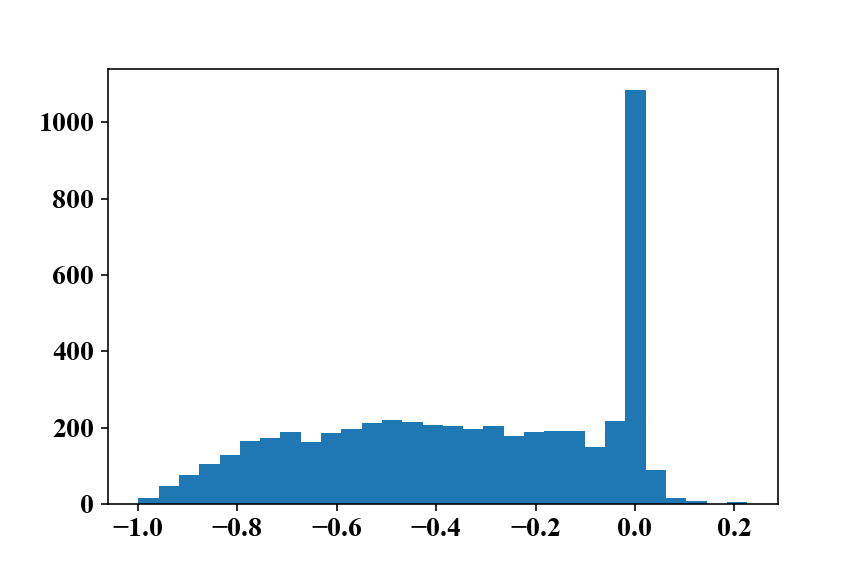

In [95]:
plt.figure()
plt.hist(edge_score, bins=30)
plt.show()

In [96]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
fit_obj = Isomap(n_components=d, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

In [97]:
edge_score

array([-0.25668323, -0.05601245, -0.7979096 , ..., -0.42235827,
       -0.7135261 , -0.8994438 ], dtype=float32)

<IPython.core.display.Javascript object>


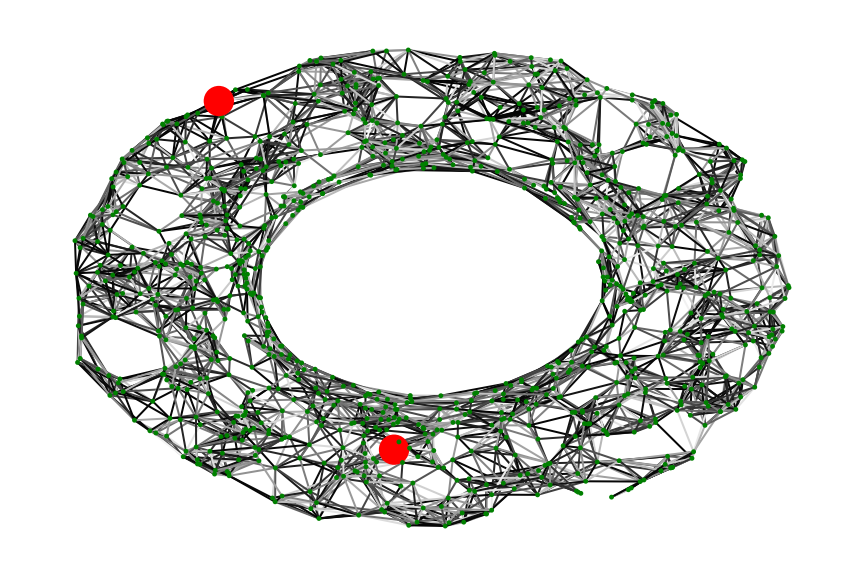

In [78]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

Bphi = B.dot(phi).reshape((w.shape[0],-1))
edge_color = np.linalg.norm(Bphi, axis=1)
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)

<IPython.core.display.Javascript object>


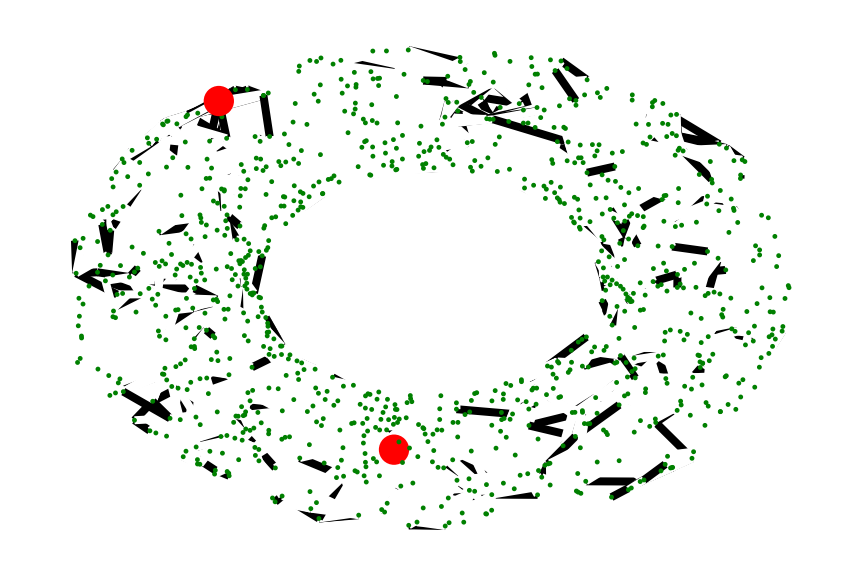

In [79]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 4,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)


<IPython.core.display.Javascript object>


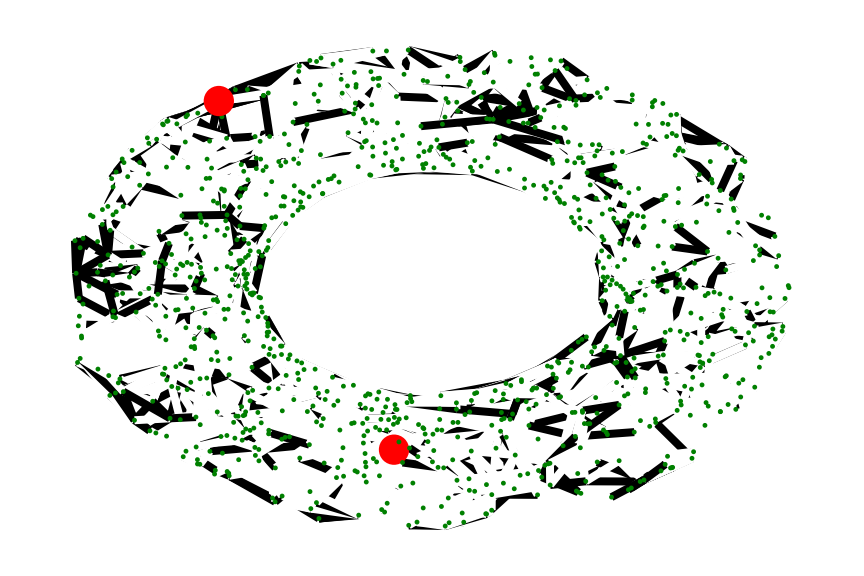

In [98]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (edge_score > 0).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 4,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
